In [1]:
%matplotlib notebook
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Loading the data

In [2]:
# Load the data 
df = pd.read_csv("data/CTA_-_Ridership_-_Daily_Boarding_Totals.csv", parse_dates=["service_date"])

# Shorten the column names
df.columns = ["date", "day_type", "bus", "rail", "total"]

# Arrange the rows in chronological order and set the date as index
df = df.sort_values("date").set_index("date")

# Drop the total column because it is only bus + rail
df = df.drop("total", axis=1)

# Drop the duplicates
df = df.drop_duplicates()

df.tail()

,day_type,bus,rail
date,,,
2022-10-27,W,528826,395129
2022-10-28,W,501985,352842
2022-10-29,A,311437,254149
2022-10-30,U,217204,177961
2022-10-31,W,454862,318942


# Multivariate time series

In [3]:
# Use both bus & rail series as input and divide the columns by 1e6 so that the data will be in the range [0-1]
df_mulvar = df[["bus", "rail"]] / 1e6 

# Include the day_type. We assume that we know tomorrow's day type. This is so that the model know's the next day's day_type
df_mulvar["next_day_type"] = df["day_type"].shift(-1)

# Apply one-hot encoding on the day_type
df_mulvar = pd.get_dummies(df_mulvar) # one-hot encode the day type

df_mulvar.head()

,bus,rail,next_day_type_A,next_day_type_U,next_day_type_W
date,,,,,
2001-01-01,0.297192,0.126455,0,0,1
2001-01-02,0.780827,0.501952,0,0,1
2001-01-03,0.824923,0.536432,0,0,1
2001-01-04,0.870021,0.550011,0,0,1
2001-01-05,0.890426,0.557917,1,0,0


# Define the train, test, and validation sets

In [4]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

# Tensorflow data format

In [5]:
tf.random.set_seed(42) 

seq_length = 56

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                        mulvar_train.to_numpy(), # use all 5 columns as input
                                                        targets=mulvar_train["rail"][seq_length:], # forecast only the rail series
                                                        sequence_length=seq_length,
                                                        batch_size=32,
                                                        shuffle=True, # shuffle the training windows
                                                        seed=42
                                                        )

valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                            mulvar_valid.to_numpy(),
                                                            targets=mulvar_valid["rail"][seq_length:],
                                                            sequence_length=seq_length,
                                                            batch_size=32
                                                            )

# Train an RNN model

In [6]:
tf.random.set_seed(42)

mulvar_model = tf.keras.Sequential([
                                    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
                                    tf.keras.layers.Dense(1)
                                    ])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", 
                                                    patience=50, 
                                                    restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, 
                                momentum=0.9)

mulvar_model.compile(loss=tf.keras.losses.Huber(), 
                      optimizer=opt, 
                      metrics=["mae"])

history = mulvar_model.fit(train_mulvar_ds, 
                            validation_data=valid_mulvar_ds, 
                            epochs=500,
                            callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 2s 21ms/step - loss: 0.0727 - mae: 0.2820 - val_loss: 0.0013 - val_mae: 0.0426
Epoch 2/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0037 - mae: 0.0671 - val_loss: 9.8296e-04 - val_mae: 0.0332
Epoch 3/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0020 - mae: 0.0430 - val_loss: 0.0011 - val_mae: 0.0361
Epoch 4/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0017 - mae: 0.0400 - val_loss: 0.0019 - val_mae: 0.0532
Epoch 5/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0016 - mae: 0.0391 - val_loss: 9.6725e-04 - val_mae: 0.0329
Epoch 6/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0015 - mae: 0.0380 - val_loss: 9.2843e-04 - val_mae: 0.0324
Epoch 7/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0015 - mae: 0.0371 - val_loss: 0.0011 - val_mae: 0.0363
Epoch 8/500
33/33 [==============================] - 0s 10ms/ste

33/33 [==============================] - 0s 11ms/step - loss: 9.4246e-04 - mae: 0.0291 - val_loss: 6.9432e-04 - val_mae: 0.0264
Epoch 62/500
33/33 [==============================] - 0s 11ms/step - loss: 9.8945e-04 - mae: 0.0299 - val_loss: 8.6544e-04 - val_mae: 0.0314
Epoch 63/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0010 - mae: 0.0317 - val_loss: 6.2885e-04 - val_mae: 0.0245
Epoch 64/500
33/33 [==============================] - 0s 10ms/step - loss: 9.8609e-04 - mae: 0.0299 - val_loss: 9.0195e-04 - val_mae: 0.0325
Epoch 65/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0010 - mae: 0.0310 - val_loss: 7.3107e-04 - val_mae: 0.0272
Epoch 66/500
33/33 [==============================] - 0s 11ms/step - loss: 9.4874e-04 - mae: 0.0293 - val_loss: 6.8045e-04 - val_mae: 0.0260
Epoch 67/500
33/33 [==============================] - 0s 11ms/step - loss: 9.6318e-04 - mae: 0.0292 - val_loss: 6.3901e-04 - val_mae: 0.0251
Epoch 68/500
33/33 [==============

33/33 [==============================] - 0s 13ms/step - loss: 9.5958e-04 - mae: 0.0301 - val_loss: 6.8234e-04 - val_mae: 0.0258
Epoch 120/500
33/33 [==============================] - 0s 13ms/step - loss: 9.1244e-04 - mae: 0.0288 - val_loss: 8.1132e-04 - val_mae: 0.0297
Epoch 121/500
33/33 [==============================] - 0s 12ms/step - loss: 9.3566e-04 - mae: 0.0293 - val_loss: 7.0629e-04 - val_mae: 0.0266
Epoch 122/500
33/33 [==============================] - 0s 11ms/step - loss: 8.9551e-04 - mae: 0.0281 - val_loss: 6.7878e-04 - val_mae: 0.0265
Epoch 123/500
33/33 [==============================] - 0s 10ms/step - loss: 9.2737e-04 - mae: 0.0288 - val_loss: 7.0675e-04 - val_mae: 0.0265
Epoch 124/500
33/33 [==============================] - 0s 10ms/step - loss: 9.0330e-04 - mae: 0.0286 - val_loss: 6.5163e-04 - val_mae: 0.0249
Epoch 125/500
33/33 [==============================] - 0s 11ms/step - loss: 9.4614e-04 - mae: 0.0298 - val_loss: 7.2158e-04 - val_mae: 0.0273
Epoch 126/500
33/33 

In [7]:
mulvar_model.evaluate(valid_mulvar_ds)[1] * 1e6

3/3 [==============================] - 0s 6ms/step - loss: 6.0519e-04 - mae: 0.0243


24254.869669675827

Very good results!

# Forecasting for multiple time steps

### First option
The task now is to forecast the next 14 values of a sequence. The first option is to use the univar_model RNN we trained earlier for the rail time series, make it predict the next value, and append the predicted value to the inputs (as if the predicted really occurred). We get the first 56 days of the validation period and use the univar_model to make a 2-week forecast.

##### Organize the data first

In [8]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

# Convert to time series format in tensorflow
seq_length = 56

train_ds = tf.keras.utils.timeseries_dataset_from_array(rail_train.to_numpy(),
                                                        targets=rail_train[seq_length:],
                                                        sequence_length=seq_length,
                                                        batch_size=32,
                                                        shuffle=True, # shuffle the training windows
                                                        seed=42)

valid_ds = tf.keras.utils.timeseries_dataset_from_array(rail_valid.to_numpy(),
                                                        targets=rail_valid[seq_length:],
                                                        sequence_length=seq_length,
                                                        batch_size=32)

test_ds = tf.keras.utils.timeseries_dataset_from_array(rail_test.to_numpy(),
                                                        targets=rail_test[seq_length:],
                                                        sequence_length=seq_length,
                                                        batch_size=32)

##### Train the univar model

In [9]:
tf.random.set_seed(42) 

univar_model = tf.keras.Sequential([
                                    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
                                    tf.keras.layers.Dense(1) # no activation function by default
                                    ])

# Stops training when the metric does not improve after 50 epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", 
                                                    patience=50, 
                                                    restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, 
                                momentum=0.9)

univar_model.compile(loss=tf.keras.losses.Huber(), 
                      optimizer=opt, 
                      metrics=["mae"])

history = univar_model.fit(train_ds, 
                            validation_data=valid_ds, 
                            epochs=500,
                            callbacks=[early_stopping_cb])

print(univar_model.evaluate(valid_ds)[1] * 1e6)

Epoch 1/500
33/33 [==============================] - 2s 21ms/step - loss: 0.0269 - mae: 0.1688 - val_loss: 0.0044 - val_mae: 0.0769
Epoch 2/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0069 - mae: 0.0838 - val_loss: 0.0028 - val_mae: 0.0542
Epoch 3/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0053 - mae: 0.0707 - val_loss: 0.0024 - val_mae: 0.0469
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0049 - mae: 0.0678 - val_loss: 0.0033 - val_mae: 0.0576
Epoch 5/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0043 - mae: 0.0627 - val_loss: 0.0029 - val_mae: 0.0534
Epoch 6/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0042 - mae: 0.0611 - val_loss: 0.0028 - val_mae: 0.0527
Epoch 7/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0040 - mae: 0.0592 - val_loss: 0.0024 - val_mae: 0.0468
Epoch 8/500
33/33 [==============================] - 0s 10ms/step - loss: 0.

33/33 [==============================] - 0s 10ms/step - loss: 0.0025 - mae: 0.0405 - val_loss: 0.0020 - val_mae: 0.0368
Epoch 63/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0025 - mae: 0.0409 - val_loss: 0.0021 - val_mae: 0.0399
Epoch 64/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0025 - mae: 0.0415 - val_loss: 0.0022 - val_mae: 0.0416
Epoch 65/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0027 - mae: 0.0433 - val_loss: 0.0018 - val_mae: 0.0296
Epoch 66/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0025 - mae: 0.0420 - val_loss: 0.0019 - val_mae: 0.0339
Epoch 67/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0025 - mae: 0.0418 - val_loss: 0.0019 - val_mae: 0.0326
Epoch 68/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0025 - mae: 0.0407 - val_loss: 0.0018 - val_mae: 0.0328
Epoch 69/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0025 

33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0392 - val_loss: 0.0018 - val_mae: 0.0340
Epoch 124/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0023 - mae: 0.0391 - val_loss: 0.0020 - val_mae: 0.0364
Epoch 125/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0026 - mae: 0.0430 - val_loss: 0.0017 - val_mae: 0.0315
Epoch 126/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0024 - mae: 0.0407 - val_loss: 0.0020 - val_mae: 0.0388
Epoch 127/500
33/33 [==============================] - 1s 22ms/step - loss: 0.0025 - mae: 0.0428 - val_loss: 0.0018 - val_mae: 0.0342
Epoch 128/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0025 - mae: 0.0409 - val_loss: 0.0022 - val_mae: 0.0456
Epoch 129/500
33/33 [==============================] - 0s 13ms/step - loss: 0.0024 - mae: 0.0420 - val_loss: 0.0019 - val_mae: 0.0368
Epoch 130/500
33/33 [==============================] - 0s 11ms/step - loss: 

In [10]:
# Gets the first 56 data and then converts the numpy array to 1x56x1 array
X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]

# Makes predictions 14 days ahead
for step_ahead in range(14):
    # Makes predictions
    y_pred_one = univar_model.predict(X)
    
    # Concatenates the predictions to ground truth values
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 28ms/step


##### Plot

<IPython.core.display.Javascript object>


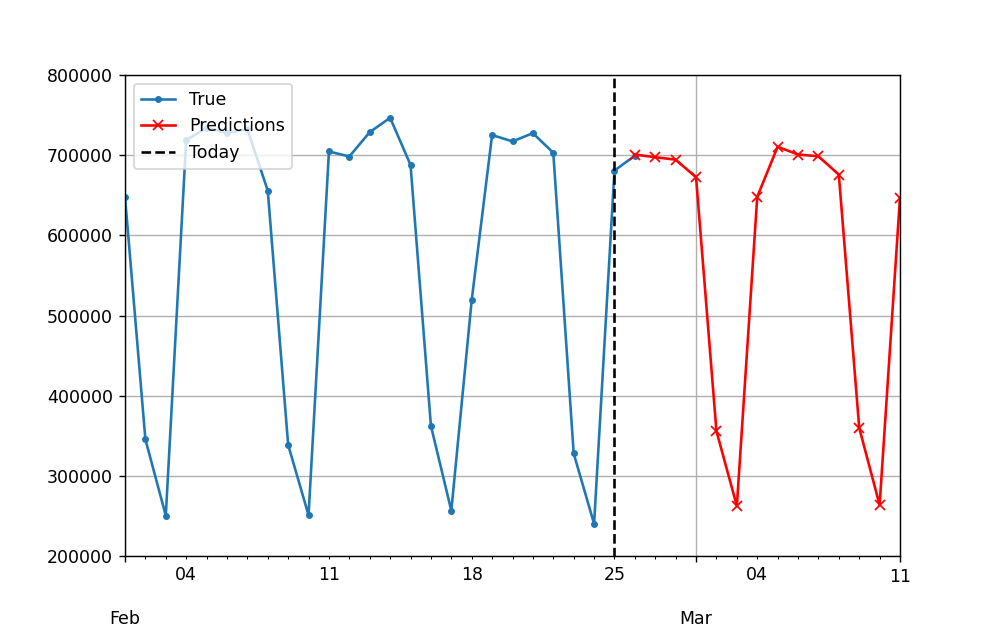

In [11]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 5))
# Plots the ground truth value
(rail_valid[:seq_length+1] * 1e6)["2019-02-01":"2019-03-11"].plot(label="True", marker=".", ax=ax)

# Plots the predicted series
(Y_pred * 1e6).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)

ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc=2)

### Second option

Another way to predict the next 14 days of the validation set is by training an RNN to predict the next 14 days **all in one shot**. So, the RNN model will be a sequence-to-vector model. We make changes to the dataset first. **We need the targets to be the next 14 days**.

To do this, we can use `timeseries_dataset_from_array()` again, but this time asking it to create datasets without targets `(targets=None)` and with longer sequences, of length `seq_length + 14`. Then we can use the datasets' `map()` method to apply a
custom function to each batch of sequences, splitting them into inputs and targets.

##### Arrange the dataset

In [12]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                            mulvar_train.to_numpy(),
                                                            targets=None,
                                                            sequence_length=seq_length + 14,
                                                            batch_size=32,
                                                            shuffle=True,
                                                            seed=42
                                                        ).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
                                                            mulvar_valid.to_numpy(),
                                                            targets=None,
                                                            sequence_length=seq_length + 14,
                                                            batch_size=32
                                                        ).map(split_inputs_and_targets)

##### Train the model

In [15]:
tf.random.set_seed(42)

# We predict the ridership in the next 14 days for rail
ahead_model = tf.keras.Sequential([
                                    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
                                    tf.keras.layers.Dense(14)
                                ])

# Stops training when the metric does not improve after 50 epochs
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_mae", 
                                                    patience=50, 
                                                    restore_best_weights=True)

opt = tf.keras.optimizers.SGD(learning_rate=0.02, 
                                momentum=0.9)

ahead_model.compile(loss=tf.keras.losses.Huber(), 
                      optimizer=opt, 
                      metrics=["mae"])

history = ahead_model.fit(ahead_train_ds, 
                            validation_data=ahead_valid_ds, 
                            epochs=500,
                            callbacks=[early_stopping_cb])

print(ahead_model.evaluate(ahead_valid_ds)[1] * 1e6)

Epoch 1/500
33/33 [==============================] - 2s 20ms/step - loss: 0.1074 - mae: 0.3470 - val_loss: 0.0309 - val_mae: 0.1893
Epoch 2/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0216 - mae: 0.1660 - val_loss: 0.0179 - val_mae: 0.1424
Epoch 3/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0168 - mae: 0.1481 - val_loss: 0.0150 - val_mae: 0.1325
Epoch 4/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0151 - mae: 0.1418 - val_loss: 0.0143 - val_mae: 0.1274
Epoch 5/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0140 - mae: 0.1353 - val_loss: 0.0128 - val_mae: 0.1235
Epoch 6/500
33/33 [==============================] - 0s 9ms/step - loss: 0.0131 - mae: 0.1309 - val_loss: 0.0120 - val_mae: 0.1176
Epoch 7/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0124 - mae: 0.1264 - val_loss: 0.0112 - val_mae: 0.1142
Epoch 8/500
33/33 [==============================] - 0s 9ms/step - loss: 0.011

Epoch 63/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0038 - mae: 0.0533 - val_loss: 0.0016 - val_mae: 0.0399
Epoch 64/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0038 - mae: 0.0531 - val_loss: 0.0017 - val_mae: 0.0405
Epoch 65/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0038 - mae: 0.0528 - val_loss: 0.0015 - val_mae: 0.0382
Epoch 66/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0038 - mae: 0.0539 - val_loss: 0.0017 - val_mae: 0.0413
Epoch 67/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0037 - mae: 0.0530 - val_loss: 0.0017 - val_mae: 0.0414
Epoch 68/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0037 - mae: 0.0528 - val_loss: 0.0016 - val_mae: 0.0406
Epoch 69/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0037 - mae: 0.0523 - val_loss: 0.0016 - val_mae: 0.0393
Epoch 70/500
33/33 [==============================] - 0s 10ms/step - 

33/33 [==============================] - 0s 10ms/step - loss: 0.0033 - mae: 0.0489 - val_loss: 0.0015 - val_mae: 0.0369
Epoch 125/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0033 - mae: 0.0486 - val_loss: 0.0014 - val_mae: 0.0360
Epoch 126/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0033 - mae: 0.0486 - val_loss: 0.0014 - val_mae: 0.0358
Epoch 127/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0033 - mae: 0.0485 - val_loss: 0.0015 - val_mae: 0.0372
Epoch 128/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0033 - mae: 0.0487 - val_loss: 0.0014 - val_mae: 0.0363
Epoch 129/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0033 - mae: 0.0484 - val_loss: 0.0015 - val_mae: 0.0370
Epoch 130/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0033 - mae: 0.0482 - val_loss: 0.0014 - val_mae: 0.0363
Epoch 131/500
33/33 [==============================] - 0s 10ms/step - loss: 

33/33 [==============================] - 0s 10ms/step - loss: 0.0031 - mae: 0.0467 - val_loss: 0.0013 - val_mae: 0.0340
Epoch 186/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0031 - mae: 0.0471 - val_loss: 0.0014 - val_mae: 0.0352
Epoch 187/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0031 - mae: 0.0463 - val_loss: 0.0013 - val_mae: 0.0342
Epoch 188/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0031 - mae: 0.0465 - val_loss: 0.0014 - val_mae: 0.0347
Epoch 189/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0031 - mae: 0.0464 - val_loss: 0.0013 - val_mae: 0.0346
Epoch 190/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0031 - mae: 0.0463 - val_loss: 0.0013 - val_mae: 0.0345
Epoch 191/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0031 - mae: 0.0466 - val_loss: 0.0014 - val_mae: 0.0359
Epoch 192/500
33/33 [==============================] - 0s 10ms/step - loss: 

33/33 [==============================] - 0s 10ms/step - loss: 0.0030 - mae: 0.0459 - val_loss: 0.0014 - val_mae: 0.0353
Epoch 247/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0030 - mae: 0.0457 - val_loss: 0.0014 - val_mae: 0.0343
Epoch 248/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0031 - mae: 0.0470 - val_loss: 0.0013 - val_mae: 0.0348
Epoch 249/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0030 - mae: 0.0455 - val_loss: 0.0013 - val_mae: 0.0337
Epoch 250/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0031 - mae: 0.0467 - val_loss: 0.0014 - val_mae: 0.0352
Epoch 251/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0031 - mae: 0.0463 - val_loss: 0.0013 - val_mae: 0.0339
Epoch 252/500
33/33 [==============================] - 0s 11ms/step - loss: 0.0030 - mae: 0.0452 - val_loss: 0.0013 - val_mae: 0.0341
Epoch 253/500
33/33 [==============================] - 0s 10ms/step - loss: 

33/33 [==============================] - 0s 11ms/step - loss: 0.0029 - mae: 0.0452 - val_loss: 0.0014 - val_mae: 0.0343
Epoch 308/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0030 - mae: 0.0451 - val_loss: 0.0014 - val_mae: 0.0358
Epoch 309/500
33/33 [==============================] - 0s 12ms/step - loss: 0.0030 - mae: 0.0453 - val_loss: 0.0016 - val_mae: 0.0396
Epoch 310/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0030 - mae: 0.0455 - val_loss: 0.0014 - val_mae: 0.0343
Epoch 311/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0030 - mae: 0.0453 - val_loss: 0.0014 - val_mae: 0.0348
Epoch 312/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0030 - mae: 0.0453 - val_loss: 0.0013 - val_mae: 0.0343
Epoch 313/500
33/33 [==============================] - 0s 10ms/step - loss: 0.0029 - mae: 0.0449 - val_loss: 0.0014 - val_mae: 0.0346
Epoch 314/500
33/33 [==============================] - 0s 11ms/step - loss: 

##### Make predictions

In [46]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

# Converts to dataframe
Y_pred_df = pd.DataFrame({'date':pd.date_range("2019-02-26", "2019-03-11"), 'Y_pred':np.ravel(Y_pred)*1e6 })
Y_pred_df.set_index("date", inplace=True)

1/1 [==============================] - 0s 22ms/step


##### Plot

<IPython.core.display.Javascript object>


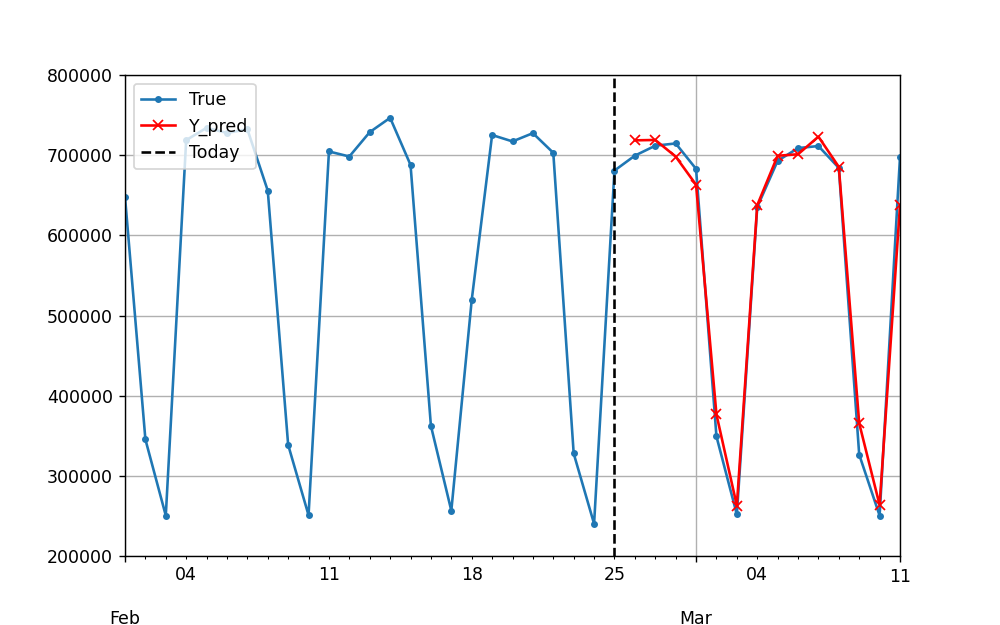

In [47]:
fig, ax = plt.subplots(figsize=(8, 5))
# Plots the ground truth value
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(label="True", marker=".", ax=ax)

# Plots the predicted series
(Y_pred_df ).plot(label="Predictions", grid=True, marker="x", color="r", ax=ax)

ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc=2)

This is better than the first option because the errors do not accumulate.

# Sequence to Sequence Model

Instead of training the model to forecast the next 14 values only at the very last step, we can train it to forecast the next 14 values at each and every time step. In other words, we can turn this sequence to vector RNN into a sequence to sequence RNN. For example, at time step 0 the model will output a vector containing the forecasts for time steps 1 to 14, then at time step 1 the model will forecast time steps 2 to 15, and so on. So, the targets are sequences of consecutive windows, shifted by one step at each time step.